In [1]:
import gym
import torch

from src.Learner.AWAC import AWAC
from src.Learner.DQN import DQN
from src.Learner.Random import DiscreteRandomAgent
from src.nn.MLP import MLP
from src.utils.memory import ReplayMemory
from src.utils.train_utils import prepare_training_inputs

import matplotlib.pyplot as plt

In [11]:
from glob import glob
path = os.getcwd()
DB_path = glob(os.path.join(path,"DB"))
print(DB_path,path)
print(os.path.join(path,"DB"))

[] c:\Users\Go\OneDrive - UOS\allrepos\AWAC_code\Pytorch-AWAC
c:\Users\Go\OneDrive - UOS\allrepos\AWAC_code\Pytorch-AWAC\DB


C:\Users\Go\miniconda3\envs\pro1\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)


(array([0.01641791, 0.01641791, 0.0119403 , 0.01492537, 0.00597015,
        0.00149254, 0.00298507, 0.00149254, 0.00149254, 0.00149254]),
 array([ 14. ,  27.4,  40.8,  54.2,  67.6,  81. ,  94.4, 107.8, 121.2,
        134.6, 148. ]),
 <BarContainer object of 10 artists>)

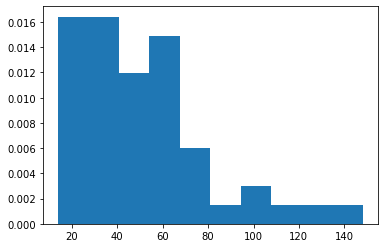

In [2]:
gamma = 0.9
memory_size = 500000
env = gym.make('CartPole-v1')
memory = ReplayMemory(memory_size)

use_expert = True
if use_expert:    
    qnet = MLP(4, 2, num_neurons=[128])
    qnet_target = MLP(4, 2, num_neurons=[128])
    dqn = DQN(4, 1, qnet=qnet,qnet_target=qnet_target, lr=1e-4, gamma=gamma, epsilon=1.0)
    state_dict = torch.load('dqn_agent.pt')
    
    # make trained agent slightly dumb
    # to simulate the realistic scenario where we don't have 'perfect' policy
    # but good enough policy.
    
    state_dict['epsilon'] = dqn.epsilon * .4 
    dqn.load_state_dict(state_dict)    
    offline_agent = dqn
    offline_budget = 50
else:
    offline_agent = DiscreteRandomAgent(2)
    offline_budget = 300

online_budget = offline_budget
cum_rs = []
for n_epi in range(offline_budget):
    s = env.reset()
    cum_r = 0

    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = offline_agent.get_action(s)
        ns, r, done, info = env.step(a)

        experience = (s,
                      torch.tensor(a).view(1, 1),
                      torch.tensor(r).view(1, 1),
                      torch.tensor(ns).view(1, 4),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        s = ns
        cum_r += 1
        if done:
            cum_rs.append(cum_r)
            break
plt.hist(cum_rs, density=True, label='expert')

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


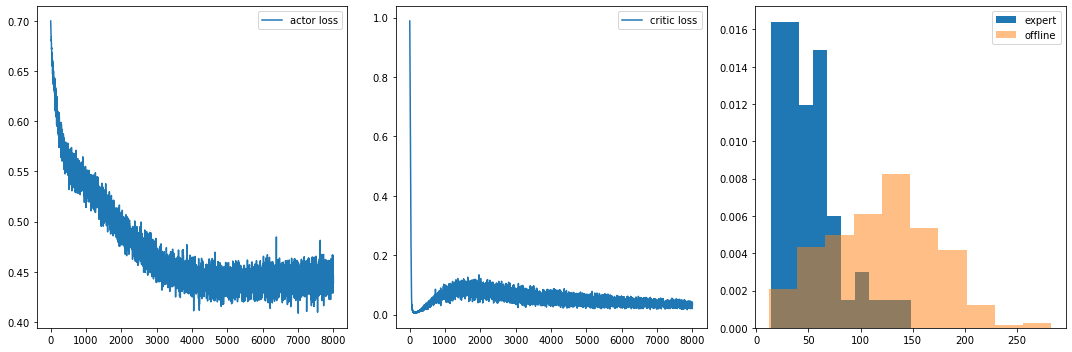

In [11]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'

qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


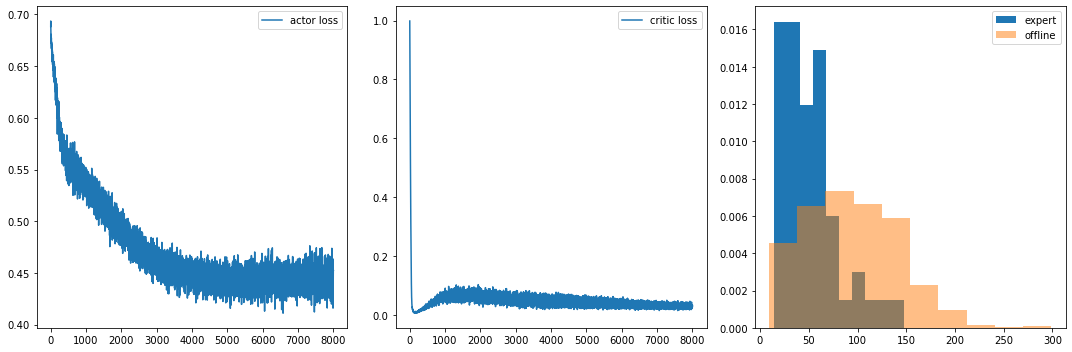

In [12]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


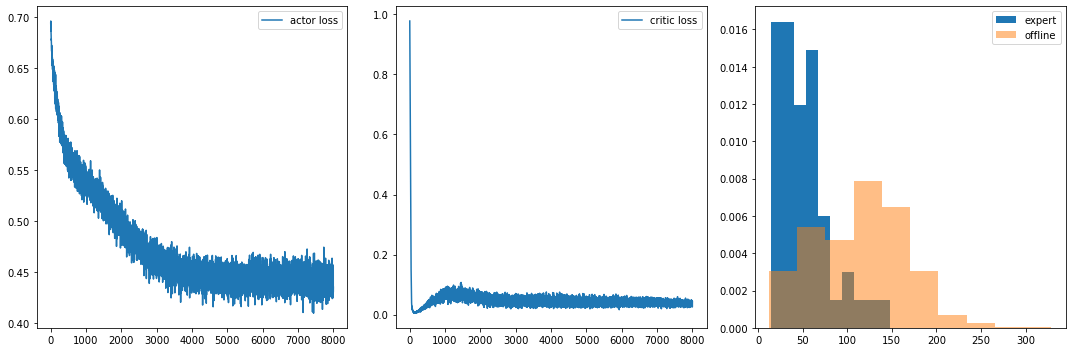

In [13]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


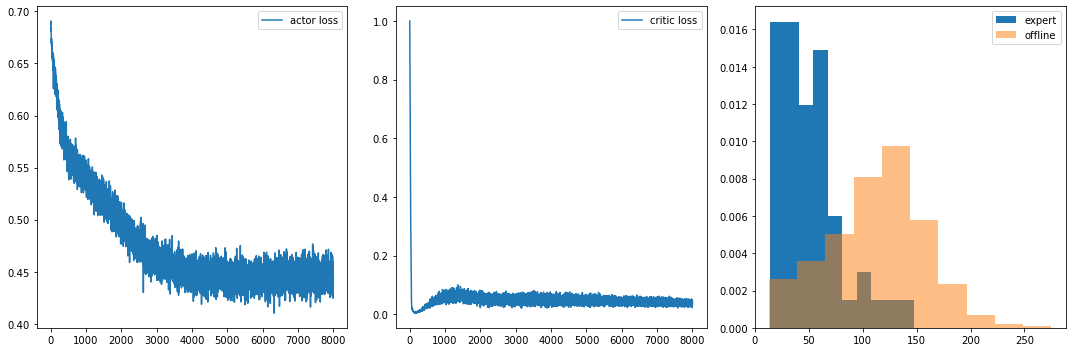

In [14]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


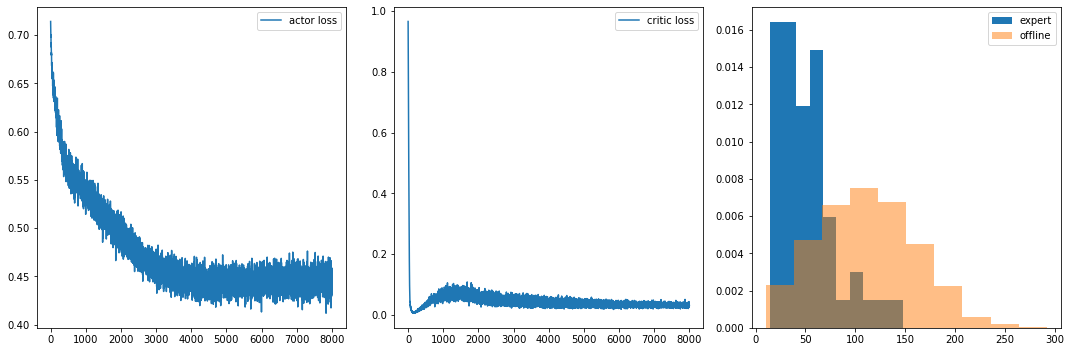

In [15]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


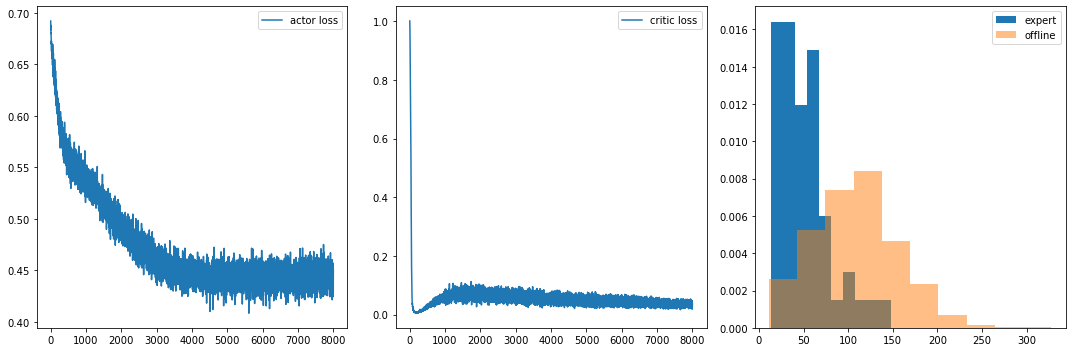

In [16]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


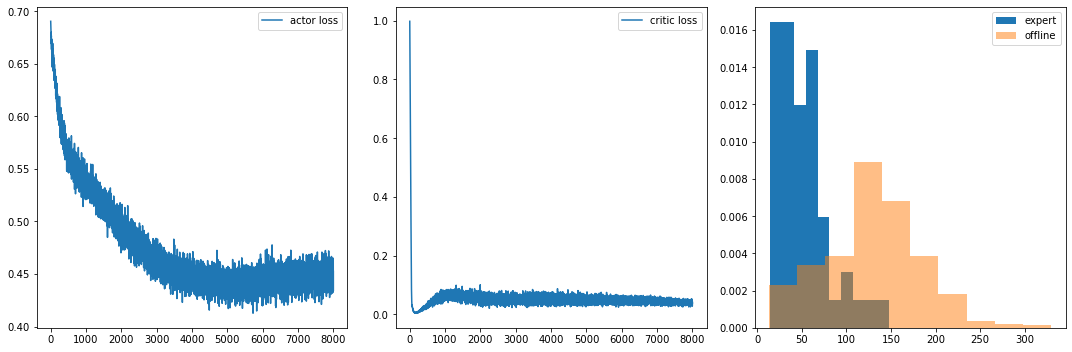

In [17]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


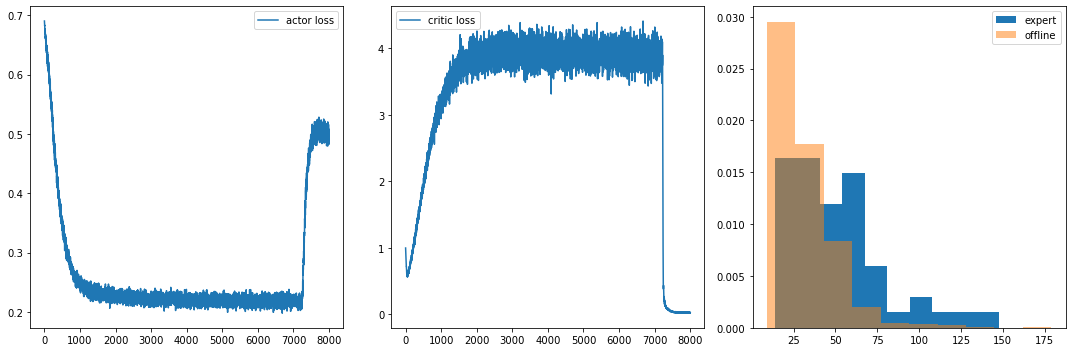

In [18]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


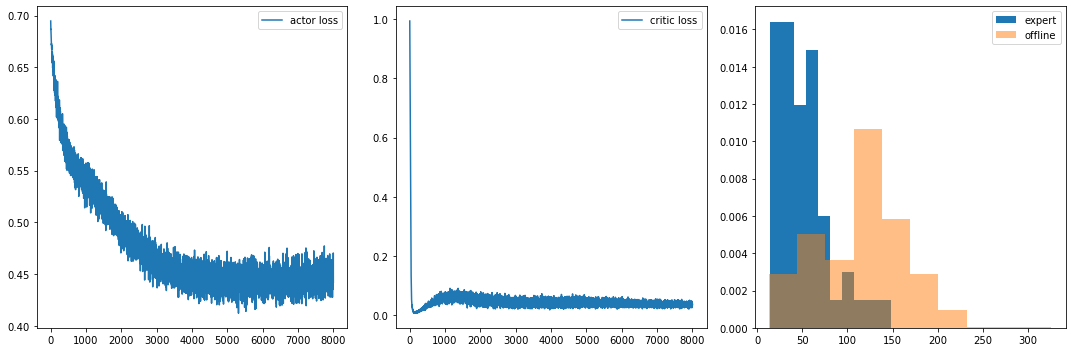

In [19]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()

fitting [0] / [8000]
fitting [1000] / [8000]
fitting [2000] / [8000]
fitting [3000] / [8000]
fitting [4000] / [8000]
fitting [5000] / [8000]
fitting [6000] / [8000]
fitting [7000] / [8000]


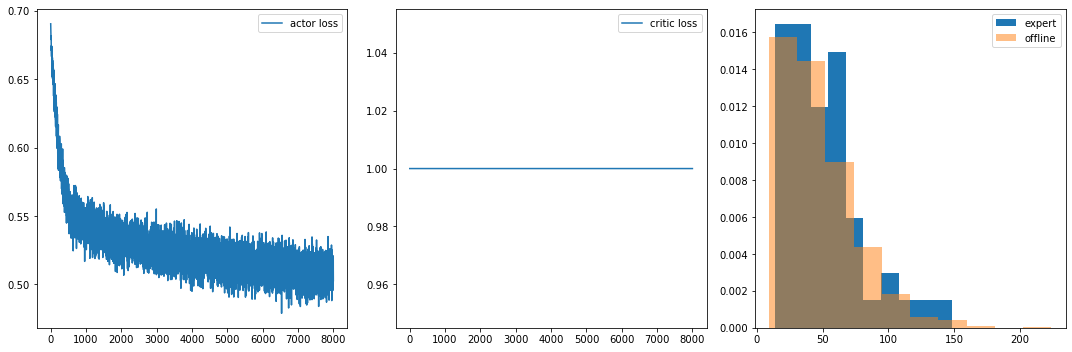

In [20]:
batch_size = 1024
n_updates = 8000
fit_device = 'cuda' if torch.cuda.is_available() else 'cpu'



qnet = MLP(4, 2, 
           num_neurons=[128,128], 
           out_act='ReLU')
qnet_target = MLP(4, 2, 
                  num_neurons=[128,128], 
                  out_act='ReLU')
pi = MLP(4, 2, num_neurons=[128,64])
use_adv = True

agent = AWAC(critic=qnet, 
             critic_target=qnet_target,
             actor=pi, 
             gamma=gamma, 
             lam=1.0, 
             num_action_samples=10,
             use_adv=use_adv)

agent.to(fit_device)
critic_losses, actor_losses = [], []
for i in range(n_updates):
    if i % 1000 == 0:
        print("fitting [{}] / [{}]".format(i, n_updates))
    sampled_exps = memory.sample(batch_size)
    s, a, r, ns, done = prepare_training_inputs(sampled_exps, 
                                                device=fit_device)    
    critic_loss = agent.update_critic(s,a,r,ns,done)
    actor_loss = agent.update_actor(s,a)
    critic_losses.append(critic_loss.detach())
    actor_losses.append(actor_loss.detach())        
agent.to('cpu')

num_runs = 1000
awac_cum_rs = []
for n_epi in range(num_runs):
    s = env.reset()
    cum_r = 0

    #어떠한 성능 기준치 이상일경우 카운트되도록
    while True:
        s = torch.tensor((s,), dtype=torch.float)
        a = int(agent.get_action(s).squeeze())
        ns, r, done, info = env.step(a)

        s = ns
        cum_r += 1
        if done:
            awac_cum_rs.append(cum_r)
            break


fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].plot(actor_losses, label='actor loss')
axes[0].legend()
axes[1].plot(critic_losses, label='critic loss')
axes[1].legend()
axes[2].hist(cum_rs, density=True, label='expert')
axes[2].legend()
axes[2].hist(awac_cum_rs, 
         alpha=0.5, 
         density=True, label='offline')
axes[2].legend()
fig.tight_layout()